In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


/var/folders/nz/4qmybzbj3nsfhgp1q_7dxz8h0000gn/T/ipykernel_16017/3538350959.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:


# Reading the CSV file without index
df = pd.read_csv('output_file.csv')

# Reading the CSV file with index
df_with_index = pd.read_csv('output_file_with_index.csv', index_col=0)

In [3]:
def l_metric_old(df, gene1, gene2, plot_hexbin=False, plot_gene_counts=False, plot_cumulative_sum=False, **kwargs):
    cell_count_df = df
    gene1_counts = cell_count_df.get(gene1)
    gene2_counts = cell_count_df.get(gene2)

    if plot_hexbin:
        mask = (gene1_counts > 0) | (gene2_counts > 0)
        gene1_counts_nozeros = gene1_counts[mask]
        gene2_counts_nozeros = gene2_counts[mask]
        plt.figure(figsize=(8, 6))
        plt.hexbin(gene1_counts_nozeros, gene2_counts_nozeros, gridsize=50, cmap='Reds', mincnt=1)
        plt.colorbar(label='Number of Cells')
        plt.title(f"Hexbin Plot of {gene1} vs. {gene2}")
        plt.xlabel(gene1)
        plt.ylabel(gene2)
        plt.show()

    df_genes = cell_count_df[[gene1, gene2]].copy()
    df_genes[f"random_{gene2}"] = np.random.permutation(df_genes[gene2].values)
    df_sorted = df_genes.sort_values(by=gene1, ascending=False)
    df_sorted.reset_index(drop=True, inplace=True)

    if plot_gene_counts:
        plt.figure(figsize=(10, 6))
        x_values = df_sorted.index
        plt.scatter(x_values, df_sorted[f"random_{gene2}"], color='green', label="Random", s=10, alpha=0.5)
        plt.scatter(x_values, df_sorted[gene1], color='blue', label=gene1, s=10, alpha=0.5)
        plt.scatter(x_values, df_sorted[gene2], color='red', label=gene2, s=10, alpha=0.5)
        plt.title('Gene Counts Comparison')
        plt.xlabel('Index')
        plt.ylabel('Counts')
        plt.legend()
        plt.show()

    df_sorted['cumsum_' + gene1] = df_sorted[gene1].cumsum()
    df_sorted['cumsum_' + gene2] = df_sorted[gene2].cumsum()
    df_sorted['cumsum_random_' + gene2] = df_sorted[f"random_{gene2}"].cumsum()

    if plot_cumulative_sum:
        plt.figure(figsize=(10, 6))
        plt.plot(df_sorted['cumsum_' + gene1], df_sorted['cumsum_' + gene2], color='red', label=f'{gene1} vs. {gene2}')
        plt.plot(df_sorted['cumsum_' + gene1], df_sorted['cumsum_random_' + gene2], color='green', label=f'{gene1} vs. Random {gene2}')
        plt.title(f'Cumulative Sum of {gene1} vs. {gene2}')
        plt.xlabel(f'Cumulative Sum of {gene1}')
        plt.ylabel(f'Cumulative Sum of {gene2}')
        plt.grid(True)
        plt.legend()
        plt.show()

    area_difference = 0
    total_area = 0
    for i in range(len(df_sorted) - 1):
        deltaX = df_sorted['cumsum_' + gene1].iloc[i+1] - df_sorted['cumsum_' + gene1].iloc[i]
        deltaY = ((df_sorted['cumsum_' + gene2].iloc[i+1] - df_sorted['cumsum_random_' + gene2].iloc[i+1]) + (df_sorted['cumsum_' + gene2].iloc[i] - df_sorted['cumsum_random_' + gene2].iloc[i])) / 2
        area_difference += deltaX * deltaY
        total_area += deltaX * (df_sorted['cumsum_' + gene2].iloc[i] + df_sorted['cumsum_' + gene2].iloc[i+1])/2

    area_difference_normalized = area_difference / (df_sorted['cumsum_' + gene1].iloc[-1] * df_sorted['cumsum_' + gene2].iloc[-1])
    total_area_normalized = total_area / (df_sorted['cumsum_' + gene1].iloc[-1] * df_sorted['cumsum_' + gene2].iloc[-1])
    return area_difference_normalized, total_area_normalized


In [4]:
def l_metric(df, gene1, gene2, plot_hexbin=False, plot_gene_counts=False, plot_cumulative_sum=False, **kwargs):
    cell_count_df = df
    gene1_counts = cell_count_df.get(gene1)
    gene2_counts = cell_count_df.get(gene2)

    if plot_hexbin:
        mask = (gene1_counts > 0) | (gene2_counts > 0)
        gene1_counts_nozeros = gene1_counts[mask]
        gene2_counts_nozeros = gene2_counts[mask]
        plt.figure(figsize=(8, 6))
        plt.hexbin(gene1_counts_nozeros, gene2_counts_nozeros, gridsize=50, cmap='Reds', mincnt=1)
        plt.colorbar(label='Number of Cells')
        plt.title(f"Hexbin Plot of {gene1} vs. {gene2}")
        plt.xlabel(gene1)
        plt.ylabel(gene2)
        plt.show()

    df_genes = cell_count_df[[gene1, gene2]].copy()
    df_genes[f"random_{gene2}"] = np.random.permutation(df_genes[gene2].values)
    df_sorted = df_genes.sort_values(by=gene1, ascending=False).reset_index(drop=True)

    if plot_gene_counts:
        plt.figure(figsize=(10, 6))
        x_values = df_sorted.index
        plt.scatter(x_values, df_sorted[f"random_{gene2}"], color='green', label="Random", s=10, alpha=0.5)
        plt.scatter(x_values, df_sorted[gene1], color='blue', label=gene1, s=10, alpha=0.5)
        plt.scatter(x_values, df_sorted[gene2], color='red', label=gene2, s=10, alpha=0.5)
        plt.title('Gene Counts Comparison')
        plt.xlabel('Index')
        plt.ylabel('Counts')
        plt.legend()
        plt.show()

    # Compute cumulative sums
    cumsum_gene1 = df_sorted[gene1].cumsum().values
    cumsum_gene2 = df_sorted[gene2].cumsum().values
    cumsum_random_gene2 = df_sorted[f"random_{gene2}"].cumsum().values

    df_sorted['cumsum_' + gene1] = cumsum_gene1
    df_sorted['cumsum_' + gene2] = cumsum_gene2
    df_sorted['cumsum_random_' + gene2] = cumsum_random_gene2

    if plot_cumulative_sum:
        plt.figure(figsize=(10, 6))
        plt.plot(cumsum_gene1, cumsum_gene2, color='red', label=f'{gene1} vs. {gene2}')
        plt.plot(cumsum_gene1, cumsum_random_gene2, color='green', label=f'{gene1} vs. Random {gene2}')
        plt.title(f'Cumulative Sum of {gene1} vs. {gene2}')
        plt.xlabel(f'Cumulative Sum of {gene1}')
        plt.ylabel(f'Cumulative Sum of {gene2}')
        plt.grid(True)
        plt.legend()
        plt.show()

    # Vectorized area calculation using the Trapezoidal Rule
    deltaX = np.diff(cumsum_gene1)  # Shape: (N-1,)

    # Calculate Y values for area_difference
    Y = cumsum_gene2 - cumsum_random_gene2  # Shape: (N,)
    deltaY = (Y[:-1] + Y[1:]) / 2  # Shape: (N-1,)

    area_difference = np.sum(deltaX * deltaY)

    # Calculate total_area
    total_Y = cumsum_gene2  # Shape: (N,)
    total_area = np.sum(deltaX * (total_Y[:-1] + total_Y[1:]) / 2)

    # Normalize the areas
    total_cumsum_gene1 = cumsum_gene1[-1]
    total_cumsum_gene2 = cumsum_gene2[-1]
    normalization_factor = total_cumsum_gene1 * total_cumsum_gene2

    area_difference_normalized = area_difference / normalization_factor
    total_area_normalized = total_area / normalization_factor

    return area_difference_normalized, total_area_normalized

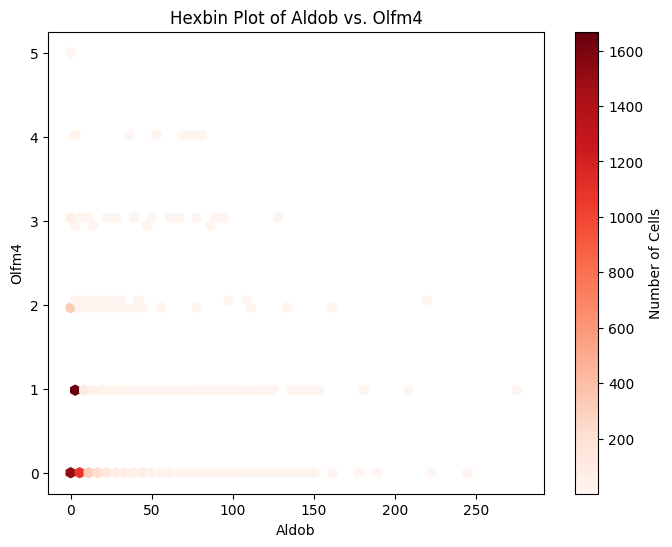

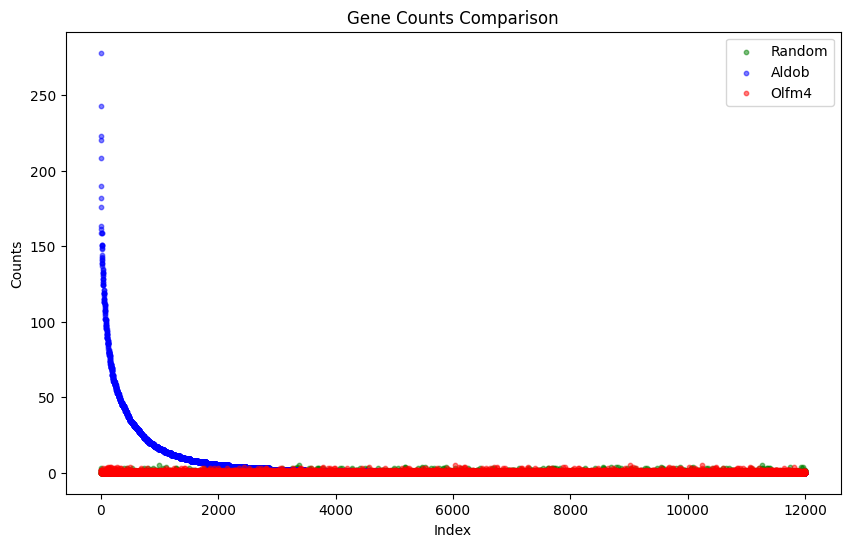

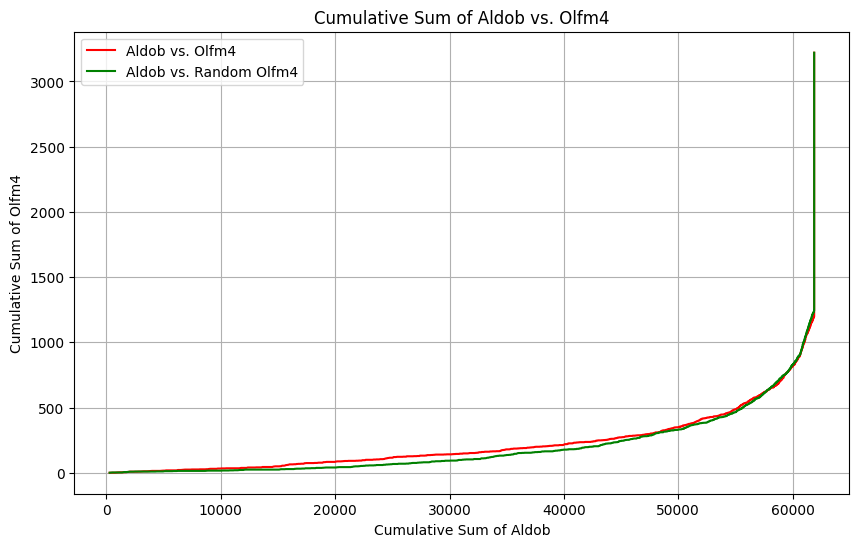

(0.008087744473573204, 0.06760990553108867)

In [5]:
l_metric_old(df, 'Aldob', 'Olfm4', plot_cumulative_sum=True, plot_gene_counts=True, plot_hexbin=True)

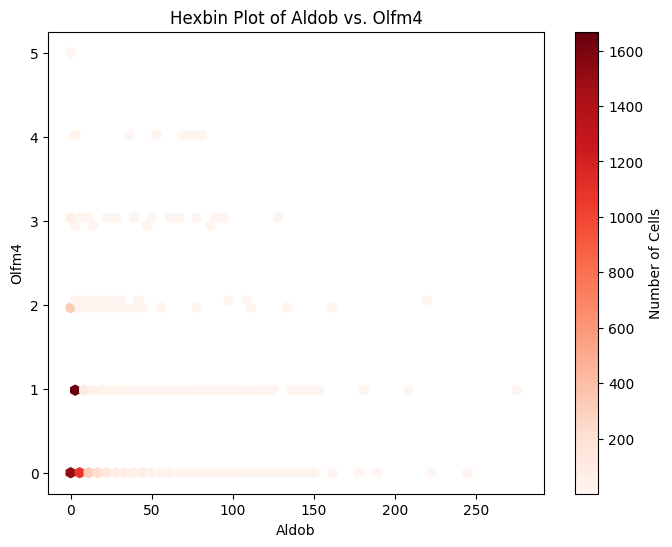

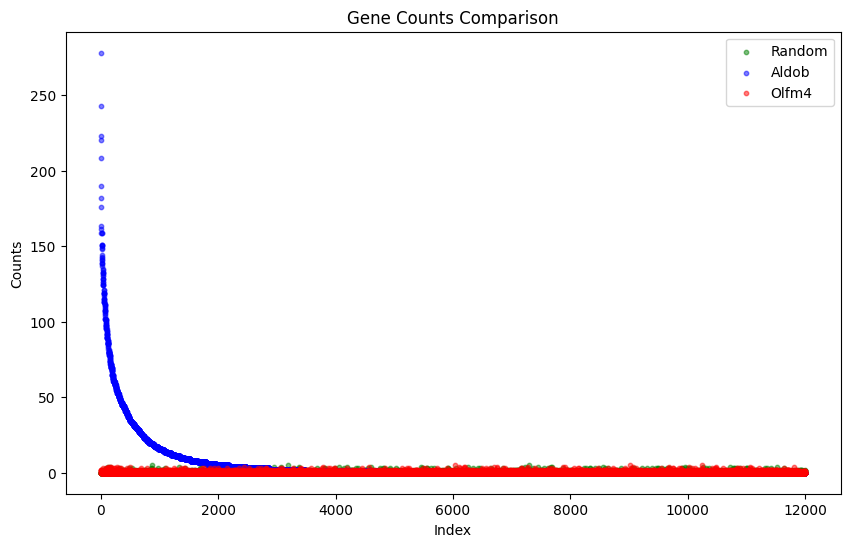

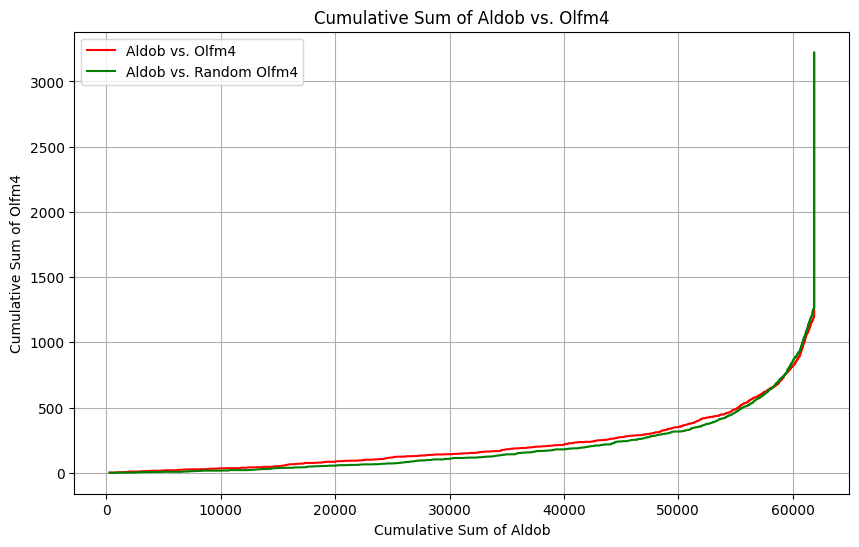

(0.0077757327093951134, 0.06760990553108867)

In [6]:
l_metric(df, 'Aldob', 'Olfm4', plot_cumulative_sum=True, plot_gene_counts=True, plot_hexbin=True)

In [7]:
import time

def benchmark_l_metrics(df, gene1, gene2, runs=100):
    """
    Benchmarks the performance of l_metric_old and l_metric functions.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - gene1 (str): The first gene.
    - gene2 (str): The second gene.
    - runs (int): Number of times to run each function.

    Returns:
    - None: Prints the benchmarking results.
    """
    # Disable plotting
    plot_hexbin = False
    plot_gene_counts = False
    plot_cumulative_sum = False

    # Initialize timing variables
    total_time_old = 0.0
    total_time_new = 0.0

    for i in range(1, runs + 1):
        # Time l_metric_old
        start_time_old = time.perf_counter()
        l_metric_old(
            df, gene1, gene2,
            plot_hexbin=plot_hexbin,
            plot_gene_counts=plot_gene_counts,
            plot_cumulative_sum=plot_cumulative_sum
        )
        end_time_old = time.perf_counter()
        elapsed_old = end_time_old - start_time_old
        total_time_old += elapsed_old

        # Time l_metric
        start_time_new = time.perf_counter()
        l_metric(
            df, gene1, gene2,
            plot_hexbin=plot_hexbin,
            plot_gene_counts=plot_gene_counts,
            plot_cumulative_sum=plot_cumulative_sum
        )
        end_time_new = time.perf_counter()
        elapsed_new = end_time_new - start_time_new
        total_time_new += elapsed_new

        # Optional: Print progress every 10 runs
        if i % 10 == 0 or i == runs:
            print(f"Completed {i}/{runs} runs")

    # Calculate average times
    average_time_old = total_time_old / runs
    average_time_new = total_time_new / runs

    # Calculate speedup
    speedup = average_time_old / average_time_new if average_time_new > 0 else float('inf')

    # Display results
    print("\nBenchmarking Results:")
    print(f"Total time for l_metric_old over {runs} runs: {total_time_old:.4f} seconds")
    print(f"Total time for l_metric over {runs} runs: {total_time_new:.4f} seconds")
    print(f"Average time per run - l_metric_old: {average_time_old:.6f} seconds")
    print(f"Average time per run - l_metric: {average_time_new:.6f} seconds")
    print(f"Speedup: l_metric is {speedup:.2f}x faster than l_metric_old")

In [8]:
# Example Genes
gene1 = 'Aldob'
gene2 = 'Olfm4'

# Ensure that the DataFrame 'df' is properly loaded
# df = pd.read_csv('your_data.csv')  # Replace with your actual data loading code

benchmark_l_metrics(df, gene1, gene2, runs=100)

Completed 10/100 runs
Completed 20/100 runs
Completed 30/100 runs
Completed 40/100 runs
Completed 50/100 runs
Completed 60/100 runs
Completed 70/100 runs
Completed 80/100 runs
Completed 90/100 runs
Completed 100/100 runs

Benchmarking Results:
Total time for l_metric_old over 100 runs: 31.1489 seconds
Total time for l_metric over 100 runs: 0.1688 seconds
Average time per run - l_metric_old: 0.311489 seconds
Average time per run - l_metric: 0.001688 seconds
Speedup: l_metric is 184.56x faster than l_metric_old


In [9]:
print(df.head())

   Ada  Add3  Adh6a  Agr2  Ahnak  Aldh1b1  Aldob  Alpi  Ang4  Anxa1  ...  \
0    0     0      0     0      0        0      0     0     0      0  ...   
1    0     0      0     0     23        0      0     0     0      6  ...   
2    0     0      0     0     38        1      1     0     0     36  ...   
3    4     0      0     0     20        0      0     0     0      0  ...   
4    0     0      0     0    188        0      1     0     0      0  ...   

   Tff3  Tm4sf20  Tm4sf4  Tph1  Tuba1a  Txndc5  Vim  Yap1  Zfp36l2  Zg16  
0     0        0       0     0       0       0    0     0        0     0  
1     0        0       1     0       0       0    0     2        1     0  
2     0        0      11     1       0       0    0     0        0     0  
3     0        0       4     0       0       0    0     2        1     0  
4     0        0     176     2       0       0    1     5        1     0  

[5 rows x 140 columns]


Computing Pairwise L-Metrics: 100%|██████████| 9730/9730 [00:11<00:00, 832.26it/s]


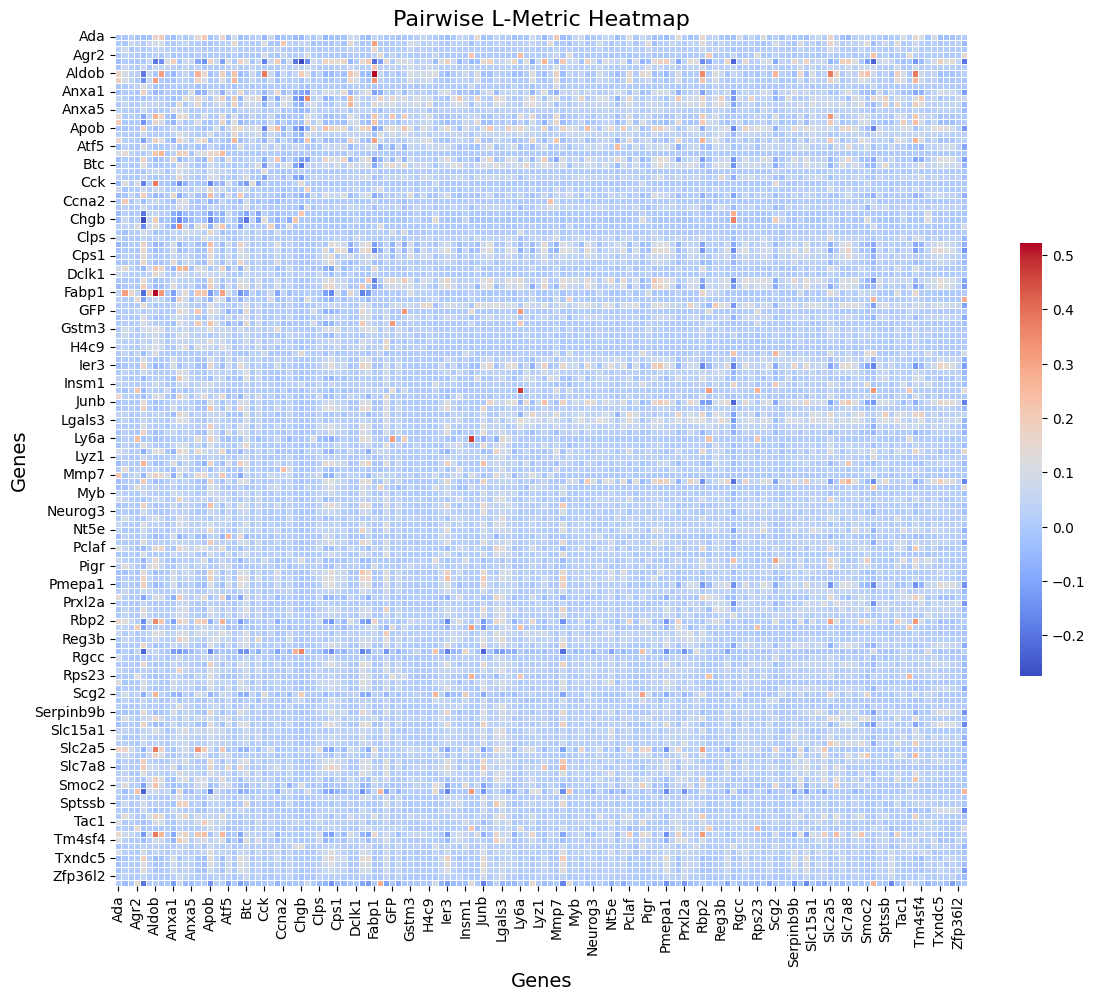

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations, permutations
from tqdm import tqdm  # For progress bars

# Assuming l_metric is already defined as per previous optimizations
# If not, ensure to define it before proceeding

def compute_all_pairwise_l_metrics(df, genes=None, metric_func=l_metric):
    """
    Computes pairwise L-metrics for all unique gene pairs in the DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing gene expression data.
    - genes (list of str, optional): Specific genes to include. If None, all genes are used.
    - metric_func (function): The function to compute the L-metric. Should accept (df, gene1, gene2).

    Returns:
    - pd.DataFrame: A DataFrame containing the computed L-metrics.
    """
    if genes is None:
        genes = df.columns.tolist()
    
    # Initialize a DataFrame to store the metrics
    metric_matrix = pd.DataFrame(
        data=np.zeros((len(genes), len(genes))),
        index=genes,
        columns=genes
    )
    
    # Generate all unique gene pairs
    gene_pairs = list(permutations(genes, 2))    

    # Iterate over each gene pair and compute the L-metric
    for gene1, gene2 in tqdm(gene_pairs, desc="Computing Pairwise L-Metrics"):
        try:
            # Compute the L-metric (select the desired metric; here, area_difference_normalized)
            area_diff, total_area = metric_func(df, gene1, gene2, plot_hexbin=False, plot_gene_counts=False, plot_cumulative_sum=False)
            
            # Store the desired metric in the matrix
            metric_matrix.loc[gene1, gene2] = area_diff  # You can choose total_area instead
            # metric_matrix.loc[gene2, gene1] = area_diff  # Assuming symmetry
        except Exception as e:
            print(f"Error computing L-metric for {gene1} and {gene2}: {e}")
            metric_matrix.loc[gene1, gene2] = np.nan
    
    return metric_matrix

def plot_heatmap(metric_matrix, title="Pairwise L-Metric Heatmap", cmap="viridis"):
    """
    Plots a heatmap of the pairwise L-metrics.

    Parameters:
    - metric_matrix (pd.DataFrame): The DataFrame containing pairwise L-metrics.
    - title (str): Title of the heatmap.
    - cmap (str): Colormap to use for the heatmap.

    Returns:
    - None: Displays the heatmap.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(metric_matrix, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)
    plt.title(title, fontsize=16)
    plt.xlabel("Genes", fontsize=14)
    plt.ylabel("Genes", fontsize=14)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Example Usage

# Load your DataFrame 'df' here
# For example:
# df = pd.read_csv('your_gene_expression_data.csv')

# Example Genes (optional)
# genes = ['Aldob', 'Olfm4', 'Gene3', 'Gene4', ...]  # Specify if you want a subset

# Compute all pairwise L-metrics
metric_matrix = compute_all_pairwise_l_metrics(df, genes=None, metric_func=l_metric)

# Plot the heatmap
plot_heatmap(metric_matrix, title="Pairwise L-Metric Heatmap", cmap="coolwarm")

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap(metric_matrix, title="Pairwise L-Metric Heatmap", cmap="coolwarm"):
    """
    Plots a clustered heatmap of the pairwise L-metrics with a diverging color scale centered at zero.

    Parameters:
    - metric_matrix (pd.DataFrame): The DataFrame containing pairwise L-metrics.
    - title (str): Title of the heatmap.
    - cmap (str): Diverging colormap to use for the heatmap.

    Returns:
    - None: Displays the clustermap.
    """
    # Determine the maximum absolute value for symmetric color scaling
    vmax = np.abs(metric_matrix.values).max()
    
    # Create a clustermap with hierarchical clustering
    g = sns.clustermap(
        metric_matrix,
        cmap=cmap,
        linewidths=.5,
        figsize=(12, 10),
        vmin=-vmax,
        vmax=vmax,
        center=0,
        method='average',        # Linkage method for clustering
        metric='euclidean',      # Distance metric for clustering
        row_cluster=True,
        col_cluster=True,
        cbar_kws={"shrink": .5, "label": "L-Metric"},
        dendrogram_ratio=(.2, .2),  # Adjust the size of dendrograms
        tree_kws=dict(linewidth=1.5)  # Customize dendrogram line width
    )
    
    # Set the title above the clustermap
    g.ax_heatmap.set_title(title, fontsize=16, pad=20)
    
    # Adjust layout to make room for the title
    plt.tight_layout()
    
    # Display the plot
    plt.show()

/Users/arjunraj/miniconda3/envs/myenv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/arjunraj/miniconda3/envs/myenv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


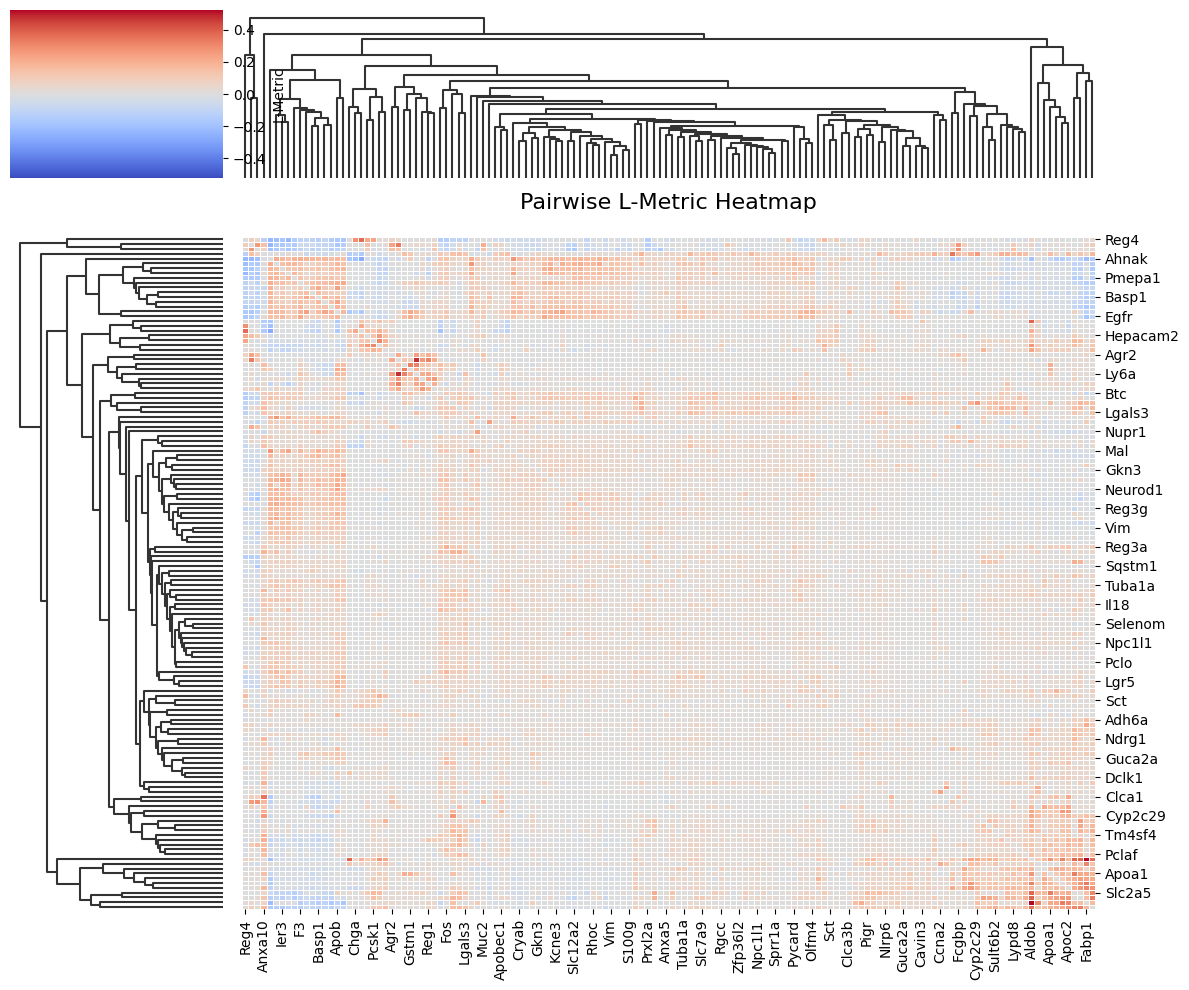

In [12]:
# Compute all pairwise L-metrics
# metric_matrix = compute_all_pairwise_l_metrics(df, genes=None, metric_func=l_metric)

# Plot the clustered heatmap with symmetric color scale
plot_heatmap(metric_matrix, title="Pairwise L-Metric Heatmap", cmap="coolwarm")